In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
import random

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<h1>Background</h1>
In this data competition, we need to identify metastatic cancer in small image patches taken from larger digital pathology scans.<br>

The train_labels.csv file provides the ground truth for the images in the train folder. We will use the train_labels.csv to train our models. Our goal is to predict the labels for the images in the test folder. <br>
A positive label indicates that the center 32x32px region of a patch contains at least one pixel of cancer tissue. <br>
The training data includes 220025 images; their ID is something that looks like this: f38a6374c348f90b587e046aac6079959adf3835. And each image is labeled with 0 or 1 for cancer detection results.


In [3]:
TRAIN_LABELS = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'
TRAIN_DIR = '/kaggle/input/histopathologic-cancer-detection/train'
TEST_DIR = '/kaggle/input/histopathologic-cancer-detection/test'
OUTPUT_DIR = Path('/kaggle/working')
df_train = pd.read_csv(TRAIN_LABELS)
df_train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [5]:
df_train.shape

(220025, 2)

<h1>Exploratory Data Analysis (EDA)</h1>

<h3>Data Structure</h3>
Firstly, let us check the training data to see the class distribution. <br>
From the visualization, we can see there are more data labeled in no tumor (0) than tumor (1). Total number is 130908 VS 89117. But overall, I think the contribution is ok for training.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw

label
0    130908
1     89117
Name: count, dtype: int64


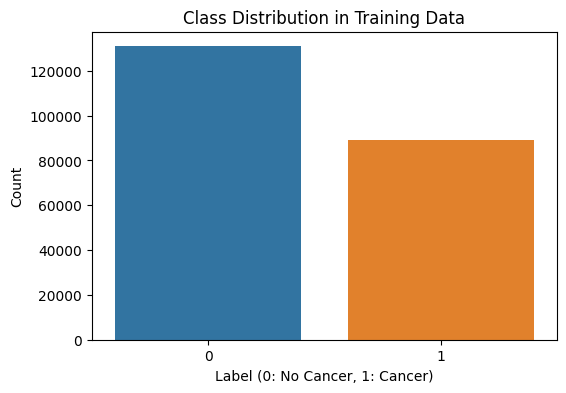

In [7]:
train_label_counts = df_train['label'].value_counts()
print (train_label_counts)
plt.figure(figsize=(6, 4))
sns.barplot(x=train_label_counts.index, y=train_label_counts.values)
plt.title('Class Distribution in Training Data')
plt.xlabel('Label (0: No Cancer, 1: Cancer)')
plt.ylabel('Count')
plt.show()

<h3>Data Cleaning</h3>
We checked the training dataset, and there is no duplicate data. So we are good for data cleaning.

In [8]:
df_train.duplicated().sum()

0

<h3>Image Visualization</h3>
We loaded the images from training folder for both tumor case and no tumor case below. <br>
Using human eye is difficult to identify cancer. So let us try how the deep learning will handle these.

In [9]:
cancer = df_train.loc[df_train['label']==1]['id'].values
noncancer = df_train.loc[df_train['label']==0]['id'].values 

print(cancer[0:5])
print(noncancer[0:5])

['c18f2d887b7ae4f6742ee445113fa1aef383ed77'
 'a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da'
 '7f6ccae485af121e0b6ee733022e226ee6b0c65f'
 'c3d660212bf2a11c994e0eadff13770a9927b731'
 '94fa32b29cc1c00403176c0795fffa3cfaa0f20e']
['f38a6374c348f90b587e046aac6079959adf3835'
 '755db6279dae599ebb4d39a9123cce439965282d'
 'bc3f0c64fb968ff4a8bd33af6971ecae77c75e08'
 '068aba587a4950175d04c680d38943fd488d6a9d'
 'acfe80838488fae3c89bd21ade75be5c34e66be7']


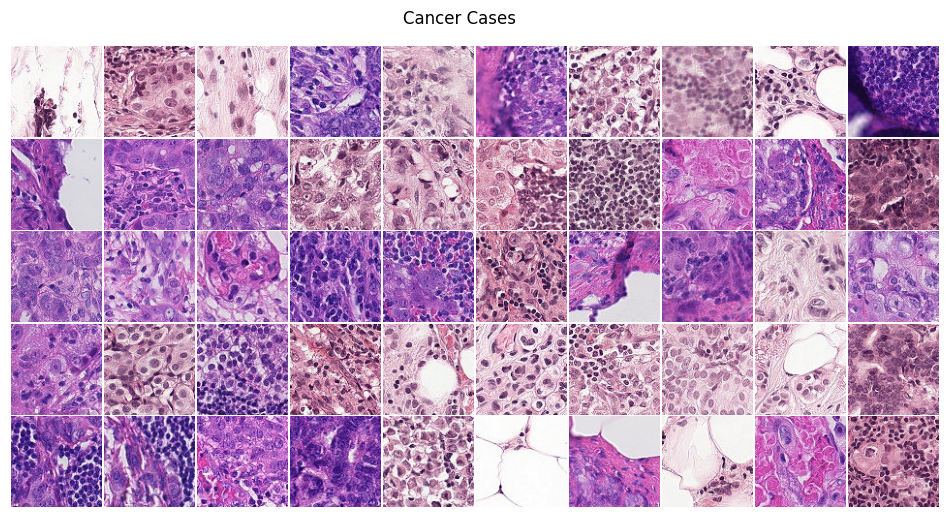

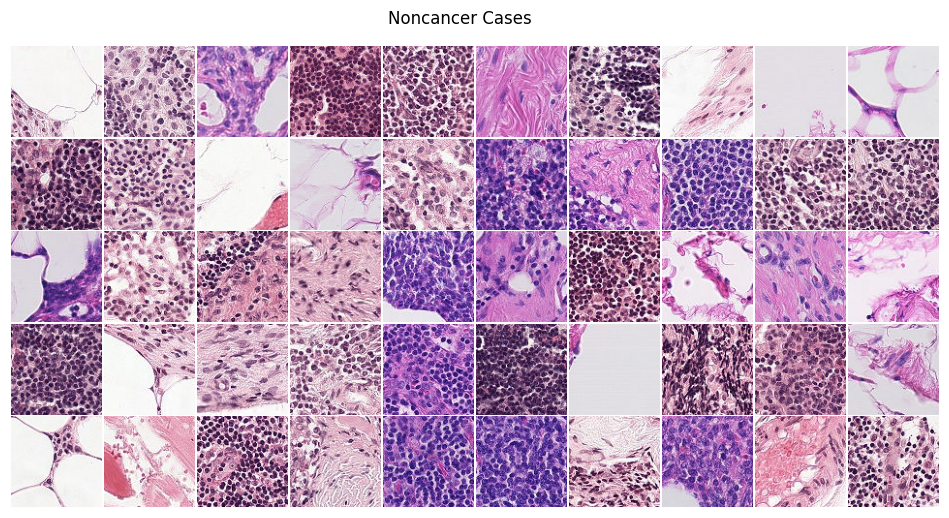

In [10]:
def plot_fig(ids,title,nrows=5,ncols=10):

    fig,ax = plt.subplots(nrows,ncols,figsize=(12,6))
    plt.subplots_adjust(wspace=0, hspace=0) 
    for i,j in enumerate(ids[:nrows*ncols]):
        fname = os.path.join(TRAIN_DIR ,j +'.tif')
        img = Image.open(fname)
        idcol = ImageDraw.Draw(img)
        idcol.rectangle(((0,0),(95,95)),outline='white')
        plt.subplot(nrows, ncols, i+1) 
        plt.imshow(np.array(img))
        plt.axis('off')

    plt.suptitle(title, y=0.94)


plot_fig(cancer,'Cancer Cases')
plot_fig(noncancer,'Noncancer Cases')

<h1>Deep Learning Models</h1>
We start preparing the cancer dataset, get RGB image and id for both training and test folders' images.

<h2>Compare 3 Models</h2>
<h3>1. TinyCNN</h3>
TinyCNN is a lightweight CNN with 3 convolution levels. Using ReLu for activation and max pooling.
<h3>2. Logistic CNN</h3>
Logistic CNN is using only 1 convolution level. No activation and using global average pooling.
<h3>3. ResNet18</h3>
ResNet18 is a more advanced model with residual connections. The skip connection solves vanishing gradients and allows deeper feature learning.



In [11]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.metrics import roc_auc_score
from torchvision.models import resnet18
from torchmetrics.classification import BinaryAUROC

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
pl.seed_everything(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Seed set to 42


In [12]:
class CancerDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["id"] + ".tif")
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        label = int(row["label"])
        return img, label

In [13]:
class CancerTestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.img_ids = sorted(os.listdir(img_dir))
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_path = os.path.join(self.img_dir, img_id)
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, img_id.replace(".tif", "")

test_tf = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
])

test_ds = CancerTestDataset(TEST_DIR, transform=test_tf)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2)

In [14]:
class TinyCNN(pl.LightningModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.lr = lr

        # --- MODEL ---
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),   # 48x48
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # 24x24
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # 12x12
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 12 * 12, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        # --- METRICS ---
        self.train_auc = BinaryAUROC()
        self.val_auc = BinaryAUROC()

    # Forward
    def forward(self, x):
        return self.classifier(self.encoder(x))

    # Training
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze(1)
        loss = F.binary_cross_entropy_with_logits(y_hat, y.float())

        # AUC update
        preds = torch.sigmoid(y_hat)
        self.train_auc.update(preds, y.int())

        self.log("train_loss", loss)
        return loss

    def on_train_epoch_end(self):
        auc = self.train_auc.compute()
        self.log("train_auc", auc, prog_bar=True)
        self.train_auc.reset()

    # Validation
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze(1)
        loss = F.binary_cross_entropy_with_logits(y_hat, y.float())

        preds = torch.sigmoid(y_hat)
        self.val_auc.update(preds, y.int())

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        auc = self.val_auc.compute()
        self.log("val_auc", auc, prog_bar=True)
        self.val_auc.reset()

    # Optimizer
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


In [15]:
class LogisticCNN(pl.LightningModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.lr = lr

        self.conv = nn.Conv2d(3, 1, kernel_size=1)

        # Add AUC metric
        self.val_auc = BinaryAUROC()

    def forward(self, x):
        x = self.conv(x)
        x = x.mean(dim=[2, 3])
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x).squeeze(1)
        loss = F.binary_cross_entropy_with_logits(logits, y.float())
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x).squeeze(1)
        loss = F.binary_cross_entropy_with_logits(logits, y.float())

        # update AUC (needs probabilities, not logits)
        probs = torch.sigmoid(logits)
        self.val_auc.update(probs, y.int())

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        auc = self.val_auc.compute()
        self.log("val_auc", auc, prog_bar=True)
        self.val_auc.reset()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


In [16]:
class ResNet18(pl.LightningModule):
    def __init__(self, lr=1e-4, pretrained=False):
        super().__init__()
        self.save_hyperparameters()

        self.model = resnet18(weights="DEFAULT" if pretrained else None)
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, 1)

        self.val_auc = BinaryAUROC()

    def forward(self, x):
        return self.model(x).squeeze(1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y.float())
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y.float())

        probs = torch.sigmoid(logits)
        self.val_auc.update(probs, y.int())

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        auc = self.val_auc.compute()
        self.log("val_auc", auc, prog_bar=True)
        self.val_auc.reset()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)


<h1>Results and Analysis</h1>

Let's check the performance result AUC for each model.<br>
<h4>TinyCNN VAL AUC: 0.96970</h4>
<h4>LogisticCNN VAL AUC: 0.63776</h4>
<h4>ResNet18 VAL AUC: 0.97673</h4>

Overall, ResNet18 performs best. It has a deeper architecture and can capture more complex features. <br>

For TinyCNN and LogisticCNN, they are more straightforward, but may be because of limited convolution levels, they may lost more information during the process.<br>
Especially, the logisticCNN with only 1 convolution level, its performance is poor.<br>

Furthermore, I optimize ResNet with different learning rates and epochs.
 

In [17]:
def train_and_evaluate(model, train_loader, val_loader, max_epochs=5, ckpt_name='model.ckpt'):
    ckpt_cb = ModelCheckpoint(dirpath=str(OUTPUT_DIR), filename=ckpt_name, monitor='val_auc', mode='max', save_top_k=1)
    trainer = pl.Trainer(max_epochs=max_epochs, accelerator='auto', devices='1', callbacks=[ckpt_cb], logger=False)
    trainer.fit(model, train_loader, val_loader)
    best_path = ckpt_cb.best_model_path
    # load best for inference
    if best_path and os.path.exists(best_path):
        best = model.__class__.load_from_checkpoint(best_path)
    else:
        best = model
    return trainer, best, best_path

In [18]:
print('Loading labels...')
df = pd.read_csv(TRAIN_LABELS)
print('Total samples:', len(df), 'Positives:', df['label'].sum())

train_tf = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
])

val_tf = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
])

train_df, val_df = train_test_split(df, test_size=0.08, stratify=df['label'], random_state=SEED)
print('Train:', len(train_df), 'Val:', len(val_df))


BATCH = 64
train_ds = CancerDataset(train_df, TRAIN_DIR, transform=train_tf)
val_ds = CancerDataset(val_df, TRAIN_DIR, transform=val_tf)
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH, shuffle=False, num_workers=4, pin_memory=True)

Loading labels...
Total samples: 220025 Positives: 89117
Train: 202423 Val: 17602


In [19]:
models_to_run = {
'TinyCNN': TinyCNN(lr=1e-3),
'LogisticCNN': LogisticCNN(lr=1e-3),
'ResNet18': ResNet18(lr=1e-4, pretrained=False)
}


history = {}
ckpt_paths = {}


for name, model in models_to_run.items():
    print('Training:', name)
    trainer, best_model, best_path = train_and_evaluate(model, train_loader, val_loader, max_epochs=5, ckpt_name=f'{name}-best')
    ckpt_paths[name] = best_path


    # evaluate on val set to collect preds for plotting & metrics
    best_model = best_model.to(device)
    best_model.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for x,y in val_loader:
            x = x.to(device)
            logits = best_model(x)
            probs = torch.sigmoid(logits).cpu().numpy().ravel()
            preds.extend(probs.tolist())
            targets.extend(y.numpy().tolist())


    auc = roc_auc_score(targets, preds)
    history[name] = {'val_preds': preds, 'val_targets': targets, 'val_auc': auc}
    print(f'{name} VAL AUC: {auc:.5f}, checkpoint: {best_path}')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training: TinyCNN


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /kaggle/working exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | encoder    | Sequential  | 23.6 K | train
1 | classifier | Sequential  | 1.2 M  | train
2 | train_auc  | BinaryAUROC | 0      | train
3 | val_auc    | BinaryAUROC | 0      | train
---------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.814     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /kaggle/working exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | conv    | Conv2d      | 4      | train
1 | val_auc | BinaryAUROC | 0      | train
------------------------------------------------
4         Trainable params
0         Non-trainable params
4         Total params
0.000     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


TinyCNN VAL AUC: 0.97326, checkpoint: /kaggle/working/TinyCNN-best.ckpt
Training: LogisticCNN


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /kaggle/working exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | model   | ResNet      | 11.2 M | train
1 | val_auc | BinaryAUROC | 0      | train
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.708    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


LogisticCNN VAL AUC: 0.63967, checkpoint: /kaggle/working/LogisticCNN-best.ckpt
Training: ResNet18


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


ResNet18 VAL AUC: 0.97708, checkpoint: /kaggle/working/ResNet18-best.ckpt


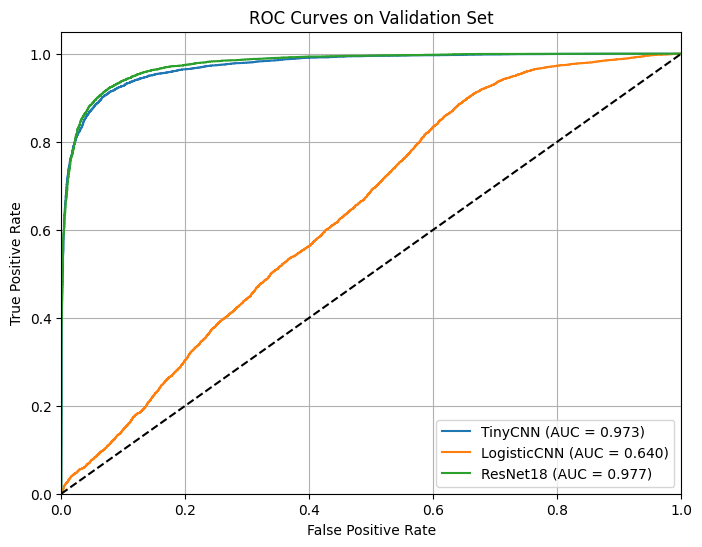

In [20]:
from sklearn.metrics import roc_curve, auc as skauc
plt.figure(figsize=(8,6))
for name, h in history.items():
    fpr, tpr, _ = roc_curve(h['val_targets'], h['val_preds'])
    roc_auc = skauc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves on Validation Set')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

<h3>Optimization</h3>
Let's optimize ResNet18 by changing the learning rates and epochs. For ResNet18, it requires more epochs to reach a good result comparing with TinyCNN or LogisticCNN. So I am increase the epochs (6, 8, 10) and test with different learning rates (1e-4, 5e-4, 1e-3).<br>
The result below shows when learning rate is 5e-4 and epochs is 10, it got the best AUC result: <br>Best model by VAL AUC: ResNet18_lr=0.0005_ep=10 AUC = 0.9889461398124695.<br>
But when I applied this best model to testing, the final result for test dataset is worse. Score is 0.9084. It is less than the previous v2, ResNet with 0.0001 and 5 epochs. So it is clearly overfitting.

In [21]:
def evaluate_model(model_class, lr, train_loader, val_loader, epochs=5):
    print(f"\n=== Testing {model_class.__name__} lr={lr}, epochs={epochs} ===")

    model = model_class(lr=lr)

    trainer = pl.Trainer(
        max_epochs=epochs,
        accelerator="auto",
        devices=1,
        logger=False,
        enable_checkpointing=False
    )

    trainer.fit(model, train_loader, val_loader)

    auc = trainer.callback_metrics.get("val_auc")
    return float(auc) if auc is not None else None


In [ ]:
# lr_list = [1e-4, 5e-4, 1e-3]
# epoch_list = [6, 8, 10]

# resnet_tuning_results = []

# for lr in lr_list:
#     for ep in epoch_list:
#         auc = evaluate_model(ResNet18, lr, train_loader, val_loader, epochs=ep)
#         resnet_tuning_results.append({
#             "model": "ResNet18",
#             "lr": lr,
#             "epochs": ep,
#             "val_auc": auc
#         })

# resnet_tuning_results = pd.DataFrame(resnet_tuning_results)

# for row in resnet_tuning_results.to_dict("records"):
#     name = f"ResNet18_lr={row['lr']}_ep={row['epochs']}"
#     history[name] = {"val_auc": row["val_auc"]}

# best_name = max(history.keys(), key=lambda n: history[n]['val_auc'])
# best_auc = history[best_name]['val_auc']

# print("Best model by VAL AUC:", best_name, "AUC =", best_auc)



In [ ]:
def rebuild_model_from_name(name):
    if "ResNet18" in name and "lr" in name:
        # Extract hyperparameters
        parts = name.replace("ResNet18_", "").split("_")
        lr = float(parts[0].split("=")[1])
        ep = int(parts[1].split("=")[1])

        print(f"Retraining best tuned ResNet18 for inference: lr={lr}, epochs={ep}")
        model = ResNet18(lr=lr)

        trainer = pl.Trainer(max_epochs=ep, accelerator="auto", devices=1, logger=False)
        trainer.fit(model, train_loader, val_loader)
        return model

    # fallback for checkpointed models
    if ckpt_paths.get(name) and os.path.exists(ckpt_paths[name]):
        return models_to_run[name].__class__.load_from_checkpoint(ckpt_paths[name])

    return models_to_run[name]

final_model = rebuild_model_from_name(best_name)
final_model = final_model.to(device)
final_model.eval()

In [ ]:
ids = []
probs = []

with torch.no_grad():
    for x, img_ids in test_loader:
        x = x.to(device)
        logits = final_model(x)
        p = torch.sigmoid(logits).cpu().numpy().ravel()
        ids.extend(img_ids)
        probs.extend(p.tolist())

submission = pd.DataFrame({'id': ids, 'label': probs})
submission_path = OUTPUT_DIR / 'submission.csv'
submission.to_csv(submission_path, index=False)
print("Saved submission to", submission_path)

print("\nSummary of Validation AUCs")
print("-" * 40)

for name, info in history.items():
    print(f"{name:35s} AUC = {info['val_auc']:.4f}")



In [ ]:
pd.read_csv('/kaggle/working/submission.csv')

<h1>Conclusion</h1>

In this project, we compared several convolutional neural network architectures—including TinyCNN, LogisticCNN, and ResNet18 and evaluated how different hyperparameters, particularly the learning rate and number of training epochs, influenced model performance.<br>
Overall, ResNet18 provided the strongest performance. But more epochs doesn't help a lot for ResNet18 Model, maybe because it is a deeper architecture and the epochs doesn't helps a lot for this stable architecture. Instead, it create an overfitting issue.Future work could extend this analysis using automated hyperparameter search methods to further optimize model performance.

<h1>Reference</h1>
ResNet18: https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html <br>
AUROC: https://lightning.ai/docs/torchmetrics/stable/classification/auroc.html

<h1>Github</h1>
Github link: https://github.com/meng-shi/Histopathologic-Cancer-Detection